In [42]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data for Apple (AAPL)
stock = yf.download("AAPL", start="2018-01-01", end="2024-12-31")

# Preview the data
stock.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.479847,40.489249,39.774869,39.986364,102223600
2018-01-03,40.472790,41.017975,40.409344,40.543288,118071600
2018-01-04,40.660789,40.764187,40.437547,40.545642,89738400
2018-01-05,41.123718,41.210664,40.665483,40.757130,94640000
2018-01-08,40.970974,41.267063,40.872274,40.970974,82271200


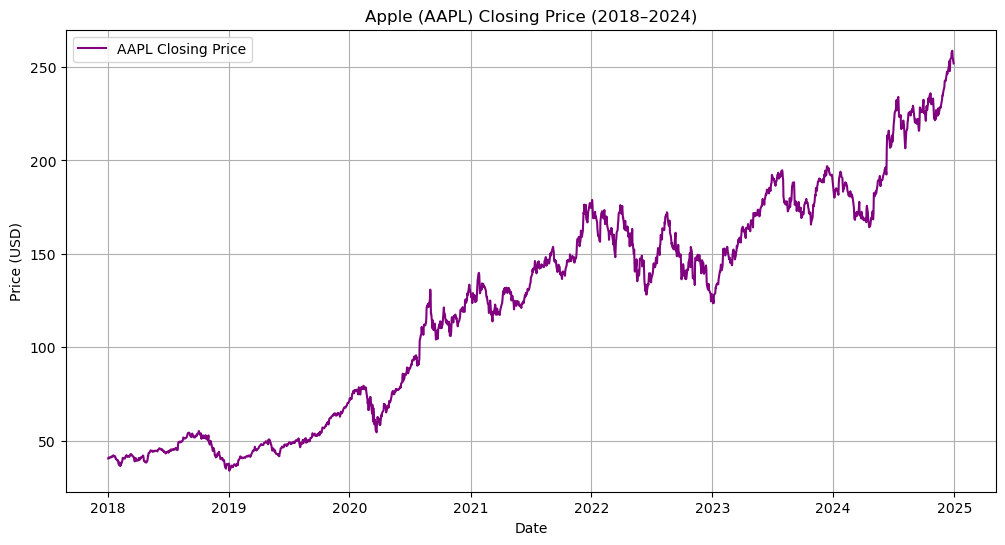

In [43]:
# Plot the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(stock['Close'], label='AAPL Closing Price', color='purple')
plt.title("Apple (AAPL) Closing Price (2018–2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Prepare the data
data = stock[['Close']].copy()
data.reset_index(inplace=True)
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Preview
data.tail()


Price,ds,y
Ticker,,AAPL
1755,2024-12-23,254.989655
1756,2024-12-24,257.916443
1757,2024-12-26,258.735504
1758,2024-12-27,255.309296
1759,2024-12-30,251.923019


In [ ]:
from prophet import Prophet

# Prepare data
df_prophet = stock.reset_index()[['Date', 'Close']]
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

# Preview the data
df_prophet.head()


Price,ds,y
Ticker,,AAPL
0,2018-01-02,40.479847
1,2018-01-03,40.472790
2,2018-01-04,40.660789
3,2018-01-05,41.123718
4,2018-01-08,40.970974


In [ ]:
# Initialize and fit the model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Create future dataframe for 180 days
future = model.make_future_dataframe(periods=180)

# Predict future values
forecast = model.predict(future)

# Preview forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


TypeError: arg must be a list, tuple, 1-d array, or Series

In [ ]:
# Drop rows with missing values (if any)
df_prophet = df_prophet.dropna()

In [ ]:
# Make sure 'ds' is datetime and 'y' is float
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = df_prophet['y'].astype(float)

In [ ]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   (ds, )     1760 non-null   datetime64[ns]
 1   (y, AAPL)  1760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.6 KB


In [ ]:
# Flatten column names
df_prophet.columns = ['ds', 'y']

# Recheck
df_prophet.head()


,ds,y
0,2018-01-02,40.479847
1,2018-01-03,40.472790
2,2018-01-04,40.660789
3,2018-01-05,41.123718
4,2018-01-08,40.970974


In [ ]:
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)


15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:12 - cmdstanpy - INFO - Chain [1] done processing


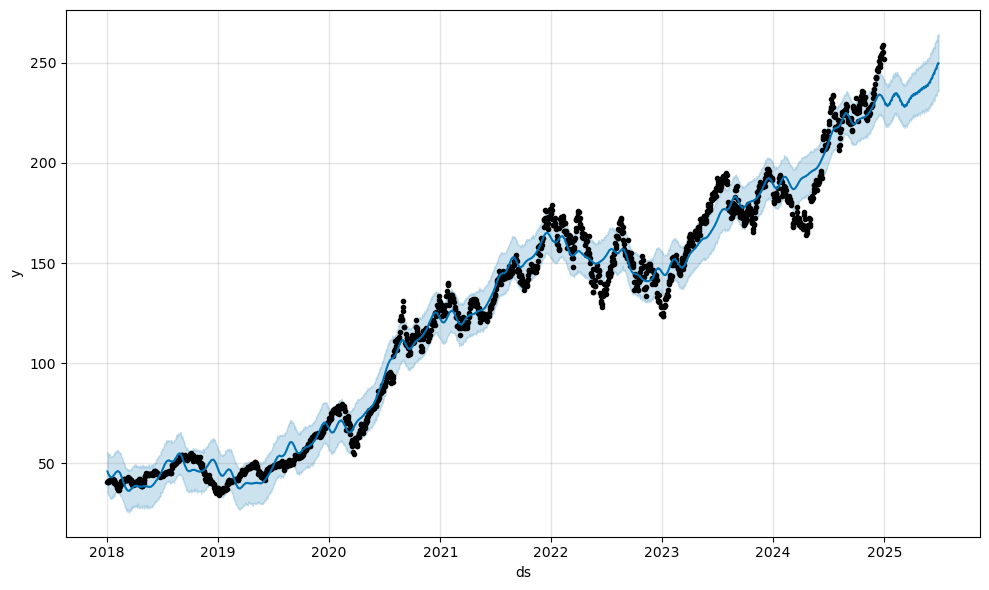

In [ ]:
# Forecast future for 180 days
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)


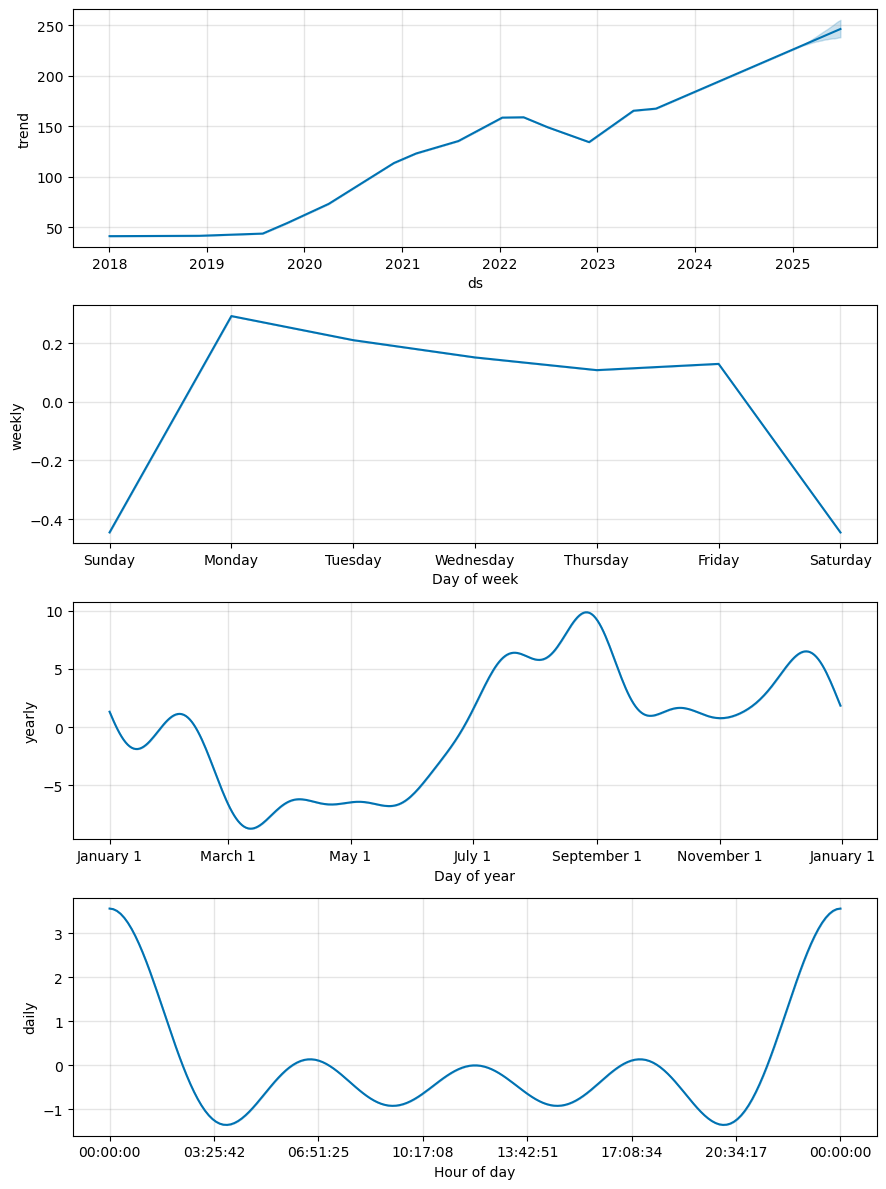

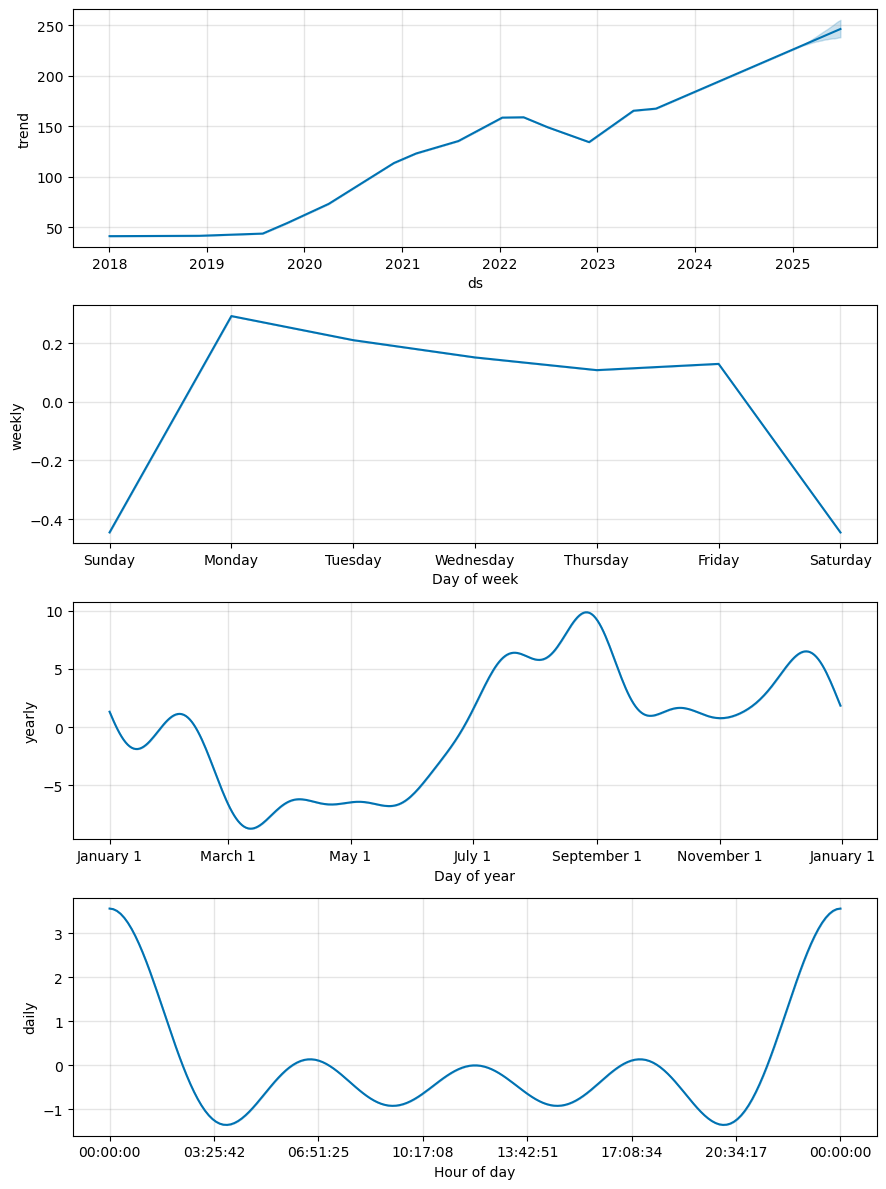

In [ ]:
model.plot_components(forecast)


In [ ]:
# Merge forecast with actuals
comparison_df = forecast[['ds', 'yhat']].merge(df_prophet, on='ds', how='left')

# Keep only rows where we have actual values (not future dates)
comparison_df = comparison_df.dropna()

# Preview
comparison_df.tail()


,ds,yhat,y
1755,2024-12-23,233.553601,254.989655
1756,2024-12-24,233.245161,257.916443
1757,2024-12-26,232.620544,258.735504
1758,2024-12-27,232.353433,255.309296
1759,2024-12-30,231.594526,251.923019


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 6.22


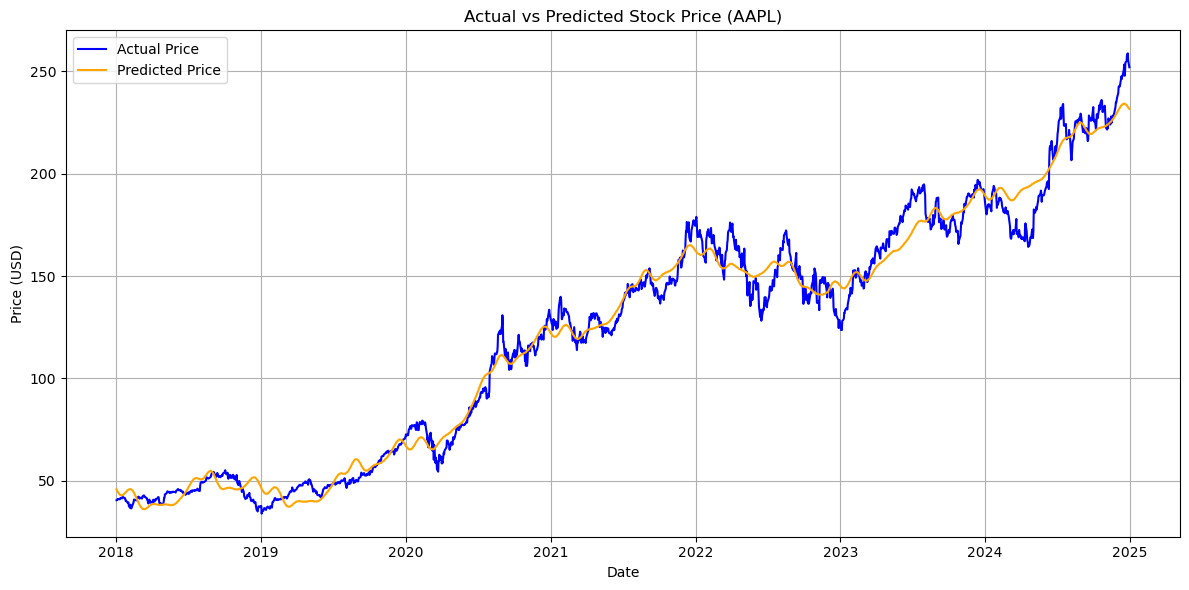

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual Price', color='blue')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Predicted Price', color='orange')
plt.title("Actual vs Predicted Stock Price (AAPL)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
ts_data = df_prophet.set_index('ds')['y']
ts_data = ts_data.asfreq('D')  # ensure regular frequency
ts_data = ts_data.fillna(method='ffill')  # fill missing dates


In [ ]:
# Fit ARIMA model
model_arima = ARIMA(ts_data, order=(5, 1, 2))
model_arima_fit = model_arima.fit()

# Summary
print(model_arima_fit.summary())


c:\Users\17814\anaconda3\envs\creditrisk\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\17814\anaconda3\envs\creditrisk\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2555
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -5258.353
Date:                Fri, 04 Apr 2025   AIC                          10532.706
Time:                        16:20:21   BIC                          10579.469
Sample:                    01-02-2018   HQIC                         10549.664
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9232      0.018    -52.703      0.000      -0.958      -0.889
ar.L2         -1.0217      0.026    -39.246      0.000      -1.073      -0.971
ar.L3         -0.0571      0.031     -1.857      0.0

c:\Users\17814\anaconda3\envs\creditrisk\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Forecast for 180 days
forecast_arima = model_arima_fit.forecast(steps=180)

# Create date range for the forecast
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=180, freq='D')

# Create forecast DataFrame
forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast_arima})
forecast_df.head()


,ds,yhat
2024-12-31,2024-12-31,251.939293
2025-01-01,2025-01-01,252.143085
2025-01-02,2025-01-02,252.131658
2025-01-03,2025-01-03,252.015751
2025-01-04,2025-01-04,252.173527


In [ ]:
# Forecast for 180 days
forecast_arima = model_arima_fit.forecast(steps=180)

# Create date range for the forecast
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=180, freq='D')

# Create forecast DataFrame
forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast_arima})
forecast_df.head()


,ds,yhat
2024-12-31,2024-12-31,251.939293
2025-01-01,2025-01-01,252.143085
2025-01-02,2025-01-02,252.131658
2025-01-03,2025-01-03,252.015751
2025-01-04,2025-01-04,252.173527


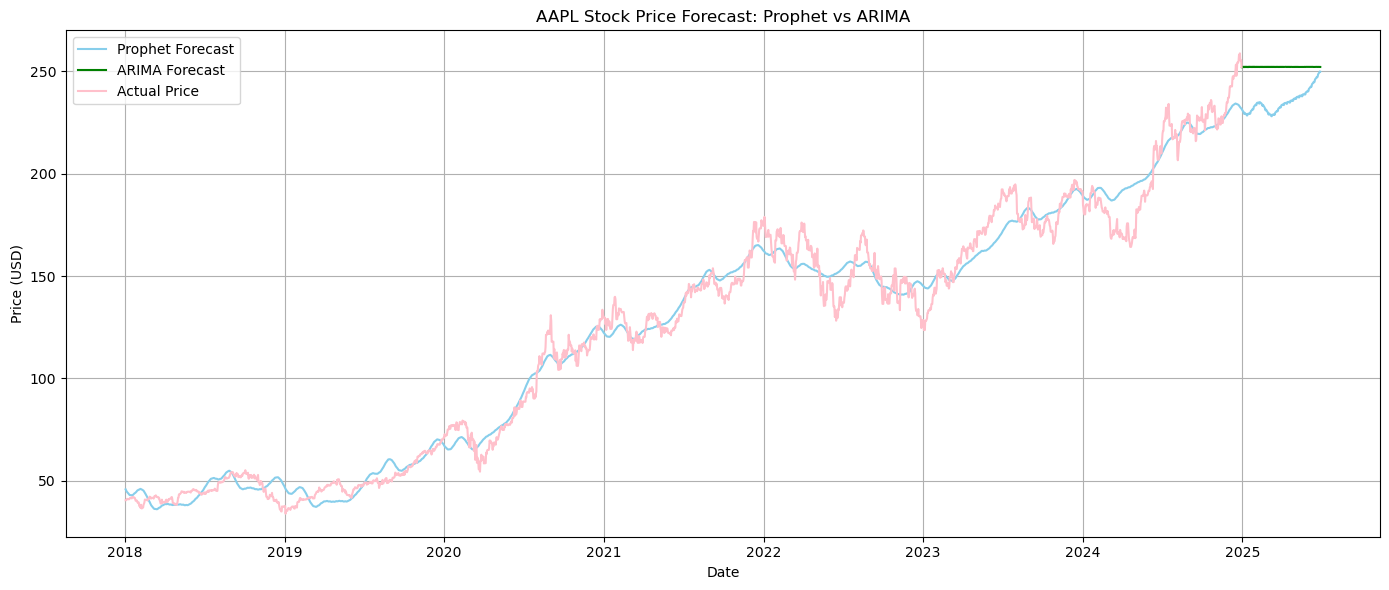

In [ ]:
plt.figure(figsize=(14, 6))

# Prophet forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='skyblue')

# ARIMA forecast
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='ARIMA Forecast', color='green')

# Actual historical prices
plt.plot(ts_data.index, ts_data, label='Actual Price', color='pink')

plt.title("AAPL Stock Price Forecast: Prophet vs ARIMA")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
